In [114]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from utils import load_data, plot_pixel_intensity_distribution


In [115]:
images, labels = load_data()

In [116]:
print(f"Images Shape: {images.shape}") 
print(f"Labels Shape: {labels.shape}")  

Images Shape: (1000, 16, 16)
Labels Shape: (1000,)


In [117]:
unique_labels, label_counts = np.unique(labels, return_counts=True)
print(f"Unique Labels: {unique_labels}")
print(f"Label Counts: {label_counts}")

Unique Labels: [0 1]
Label Counts: [500 500]


### Observations
- There are only two labels in this dataset which are *0* and *1*. This shows that it is a **binary classification problem**.
- Each label appears 500 times. This shows that the dataset is perfectly balanced.
- There is no need for **class weighting, oversampling, or undersampling**, as both classes have equal representation.

## Dataset Description

- The dataset consists of **1000 grayscale images**, each of size **16x16 pixels**.
- Each image belongs to one of **two labels**:
  - **Label 0**: Background (No clear structure, scattered noise).
  - **Label 1**: Object (Brighter regions, structured patterns).
- Since each class appears **500 times**, this dataset is **balanced**, meaning no need for oversampling or class weighting.


### Exploratory Data Analysis(EDA)

### Step 1

First I will visualise sample images to see how the different labelled images are different from each other and how are they different

This is done below

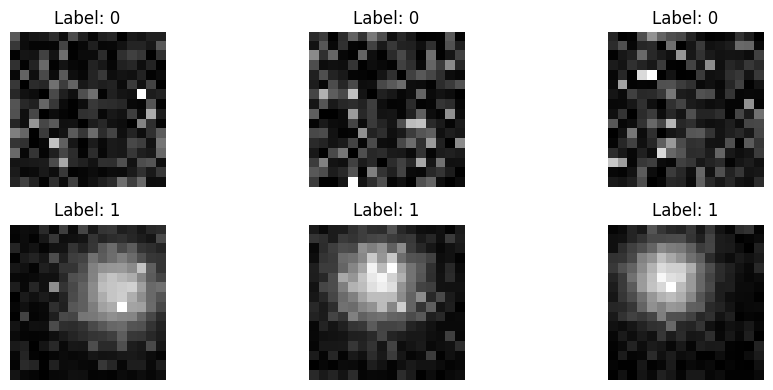

In [118]:
plt.figure(figsize=(10, 4))

# Find indices of label 0 and label 1
idx_0 = np.where(labels == 0)[0][:3]  # First 3 samples of class 0
idx_1 = np.where(labels == 1)[0][:3]  # First 3 samples of class 1

# Plot images with Label 0
for i, idx in enumerate(idx_0):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[idx], cmap='gray')
    plt.title("Label: 0")
    plt.axis("off")

# Plot images with Label 1
for i, idx in enumerate(idx_1):
    plt.subplot(2, 3, i+4)
    plt.imshow(images[idx], cmap='gray')
    plt.title("Label: 1")
    plt.axis("off")

plt.tight_layout()
plt.show()

### Observations
- The images dataset consists of 16x16 greyscale images that are either labelled 0 or 1
- Class 0(Top Row)
  - These images are scattered and have **no clear structure**
  - Appear to have some **random noise**
- Class 1(Bottom Row)
  - These images are more **structured** and show regions of bright intensity
  - Shows some sort of **concentrated image** like a lightsource or galaxy

### Step 2

Secondly since I have seen from above there is some amount of pixel intensity difference between the two labels of images, my next step will be to create a histogram to mathematically see how much the pixel intensity differs between Class 0 and Class 1

This is done below


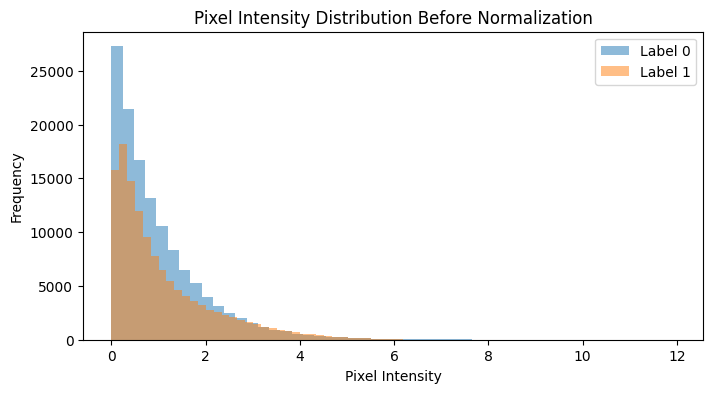

In [119]:
plot_pixel_intensity_distribution(images, labels, "Pixel Intensity Distribution Before Normalization")

### Observations
- The majority of pixels(for both Label 0 and Label 1) have low intensity(close to 0)
- Data Labelled 1 has a higher spread indicating that images with label 1 contain **brighter pixels**
- The pixel brightness rarely exceeds 4 which indicates that bright pixels are relatively uncommon
- There is a **long tail towards higher intensities**, but very few pixels have intensity above **8**


In [120]:
pixel_values_0 = images[labels == 0].flatten()
pixel_values_1 = images[labels == 1].flatten()

print(f"Maximum pixel intensity of Label 0 is {max(pixel_values_0)}")
print(f"Maximum pixel intensity of Label 1 is {max(pixel_values_1)}")

Maximum pixel intensity of Label 0 is 11.959763499698632
Maximum pixel intensity of Label 1 is 8.35401311490326


Another interesting observation I see is that the maximum value of Label 0 data is more than that of Label 1 data which indicates the presence of some outliers

In [121]:
print(f"Max pixel in Label 0: {np.max(pixel_values_0)}")
print(f"Max pixel in Label 1: {np.max(pixel_values_1)}")
print(f"99th percentile of Label 0: {np.percentile(pixel_values_0, 99)}")
print(f"99th percentile of Label 1: {np.percentile(pixel_values_1, 99)}")

Max pixel in Label 0: 11.959763499698632
Max pixel in Label 1: 8.35401311490326
99th percentile of Label 0: 4.6223081187058765
99th percentile of Label 1: 4.649658310778583


## Outlier Detection in Pixel Intensities

### **Key Findings**
- The **maximum pixel intensity in Label 0** is **11.96**, which is higher than **Label 1** (8.35).
- However, the **99th percentile for both Label 0 and Label 1 is around ~4.6**, meaning that **most pixel values are below this threshold**.
- This indicates that **the high values in Label 0 are outliers** rather than a normal characteristic of the class.

### **Interpretation**
- The **majority of pixel intensities are within the 0 to 4.6 range**, but Label 0 has **a few extreme bright pixels** that might be due to **noise or artifacts**.
- Since **outliers in Label 0** could affect model training, we should consider **normalization strategies** to prevent the model from learning incorrect features.

### Next Steps

Now I would normalise the data but instead of normalising using the maximum value we can normalise using the 99th percentile

In [122]:
# Apply Percentile Normalization (Using 99th Percentile)
percentile_99 = np.percentile(images, 99)
images_normalized = images / percentile_99  # Scale pixel values using 99th percentile

# Verify normalization
print(f"New Min: {np.min(images_normalized)}, New Max: {np.max(images_normalized)}")

New Min: 1.85142888272182e-07, New Max: 2.577302055768138


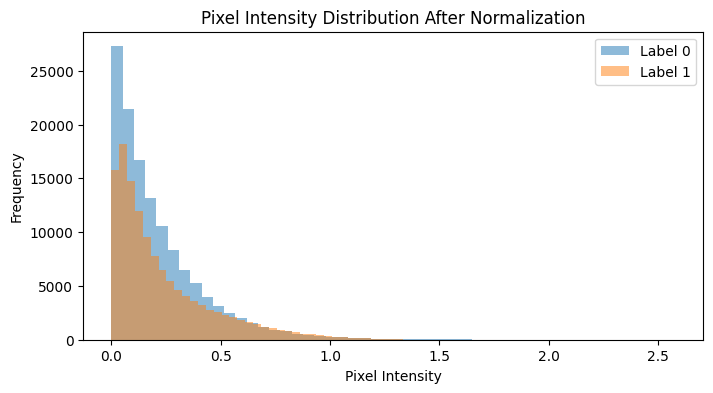

In [123]:
plot_pixel_intensity_distribution(images_normalized, labels, "Pixel Intensity Distribution After Normalization")

### Observations
- The **new pixel intensity range** is from **~0 to ~2.57** instead of **0 to 12**.
- The histogram after normalization **preserves the overall shape** while preventing outliers from dominating.
- Label 0 and Label 1 still show **different intensity distributions**, meaning pixel intensity remains a useful feature for classification.

## Summary of Exploratory Data Analysis (EDA)

- **Key Differences Between Label 0 and Label 1**:
  - **Label 0**: Appears noisy, has mostly **low-intensity pixels**, no clear structure.
  - **Label 1**: Contains **brighter regions**, possibly representing **galaxies or light sources**.
- **Brightness is a useful feature**:
  - **Histogram shows** that Label 1 images **contain more bright pixels** compared to Label 0.
- **Outliers Detected**:
  - Label 0 had a **maximum pixel intensity of 11.96**, while Label 1 was 8.35.
  - Since the **99th percentile was ~4.6**, we applied **percentile normalization** to handle outliers.
- **Next Steps**:
  - Evaluate the provided model’s performance 
  - Check if the model is **learning correctly** and analyze its **classification results**.

## Analysis of the Given Model


In [124]:
import tensorflow as tf
from keras.layers import TFSMLayer # type: ignore

In [125]:
# Load the model
model_path = "model/" 
model = TFSMLayer(model_path, call_endpoint="serving_default")

# Print model input and output shapes
print("Model Config:", model.get_config())
print("Expected Input:", model.input_spec)

Model Config: {'name': 'tfsm_layer_4', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filepath': 'model/', 'call_endpoint': 'serving_default', 'call_training_endpoint': None}
Expected Input: None


### Observations
- The model is trainable telling me that fine-tuning is possible
- The model does not define an input shape 

In [126]:
loaded_model = tf.saved_model.load(model_path)

print("Available Signatures:", list(loaded_model.signatures.keys()))

Available Signatures: ['serving_default']


In [127]:
print("Serving Signature:", loaded_model.signatures["serving_default"])

Serving Signature: ConcreteFunction Input Parameters:
  input_1 (KEYWORD_ONLY): TensorSpec(shape=(None, 16, 16), dtype=tf.float32, name='input_1')
Output Type:
  Dict[['lambda', TensorSpec(shape=(None,), dtype=tf.float32, name='lambda')]]
Captures:
  None


In [128]:
print("Input Details:", loaded_model.signatures["serving_default"].inputs)
print("Output Details:", loaded_model.signatures["serving_default"].outputs)

Input Details: [<tf.Tensor 'input_1:0' shape=(None, 16, 16) dtype=float32>]
Output Details: [<tf.Tensor 'Identity:0' shape=(None,) dtype=float32>]


## Observations
- The model contains **one available signature**: `"serving_default"`.
- The **serving signature** expects:
  - **Input Tensor (`input_1`)**:
    - Shape: `(None, 16, 16)` → Model accepts **16x16 matrices** with an unspecified batch size.
    - Data Type: `float32`.
  - **Output Tensor (`lambda`)**:
    - Shape: `(None,)` → Produces a **single float value** per input.
    - Data Type: `float32`.

- Input and Output Details
- **Input**: The model requires a **16×16 float32 matrix** as input.
- **Output**: The model returns a **single float value** per input instance.
- **Captured Variables**: None (i.e., no additional saved model states are used).

### Next Steps
- Since the model expects a 16x16 matrix, I will now try to pass the 16x16 pixel image as an input in the model using the normalized dataset

In [129]:
input_image = images[0]  # Shape: (16,16)

input_tensor = tf.constant(input_image.reshape(1, 16, 16), dtype=tf.float32)  # Shape: (1, 16, 16)

# Run inference
infer = loaded_model.signatures["serving_default"]
output = infer(input_1=input_tensor)  

print("Model Output:", output)

Model Output: {'lambda': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([244.7044], dtype=float32)>}


In [130]:
for i in range(6):  # Test first 5 images
    input_tensor = tf.constant(images[i].reshape(1, 16, 16), dtype=tf.float32)
    output = infer(input_1=input_tensor) 
    print(f"Image {i} Output:", output)

Image 0 Output: {'lambda': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([244.7044], dtype=float32)>}
Image 1 Output: {'lambda': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([246.41003], dtype=float32)>}
Image 2 Output: {'lambda': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([266.45758], dtype=float32)>}
Image 3 Output: {'lambda': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([287.88647], dtype=float32)>}
Image 4 Output: {'lambda': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([289.0215], dtype=float32)>}
Image 5 Output: {'lambda': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([273.17194], dtype=float32)>}


##### Since i know from  previous code that image 0,1,2 are label 0 and image 3,4,5 are label 1, i see that label 1 output is in the 280-290 range while label 0 output is in the 240-260 range

##### Let me compute the average of the output of label 0 and label 1 images to be certain

In [131]:
sum_label_0, sum_label_1 = 0, 0
count_label_0, count_label_1 = 0, 0

# Loop through all images and calculate outputs
for i in range(len(images)):  
    input_tensor = tf.constant(images[i].reshape(1, 16, 16), dtype=tf.float32)
    output = infer(input_1=input_tensor) 
    output_value = output["lambda"].numpy()[0]  # Extract float value

    # Check corresponding label
    if labels[i] == 0:
        sum_label_0 += output_value
        count_label_0 += 1
    else:
        sum_label_1 += output_value
        count_label_1 += 1

# Calculate averages
avg_label_0 = sum_label_0 / count_label_0 if count_label_0 > 0 else 0
avg_label_1 = sum_label_1 / count_label_1 if count_label_1 > 0 else 0

print(f"Average Output for Label 0: {avg_label_0:.4f}")
print(f"Average Output for Label 1: {avg_label_1:.4f}")

Average Output for Label 0: 255.9986
Average Output for Label 1: 281.5326


##### I observe that the average output value for **label 0 is ~255** while that of **label 1 is ~281** which proves my hypothesis

##### Now let me do the same procedure for the normalised images dataset

In [132]:
sum_label_0, sum_label_1 = 0, 0
count_label_0, count_label_1 = 0, 0

# Loop through all images and calculate outputs
for i in range(len(images_normalized)):  
    input_tensor = tf.constant(images_normalized[i].reshape(1, 16, 16), dtype=tf.float32)
    output = infer(input_1=input_tensor) 
    output_value = output["lambda"].numpy()[0]  # Extract float value

    # Check corresponding label
    if labels[i] == 0:
        sum_label_0 += output_value
        count_label_0 += 1
    else:
        sum_label_1 += output_value
        count_label_1 += 1

# Calculate averages
avg_label_0_n = sum_label_0 / count_label_0 if count_label_0 > 0 else 0
avg_label_1_n = sum_label_1 / count_label_1 if count_label_1 > 0 else 0

print(f"Average Output for Label 0: {avg_label_0_n:.4f}")
print(f"Average Output for Label 1: {avg_label_1_n:.4f}")

Average Output for Label 0: 55.1671
Average Output for Label 1: 60.6696


##### For the normalised dataset I also get a clear difference but it is likely to be trained on the non normalised dataset

##### However with raw outputs it is unclear to set threshold so my idea is to use the sigmoid function to convert the output values into value between 0 and 1. The reason is that if the probabiliy is above 0.5 we can predict it as a Label 1 image

In [133]:
for i in range(10):
    raw_score = output["lambda"].numpy()[0]  # Extract float value
    probability = tf.nn.sigmoid(raw_score).numpy()
    print(f"Image {i} Probability: {probability:.4f}")

Image 0 Probability: 1.0000
Image 1 Probability: 1.0000
Image 2 Probability: 1.0000
Image 3 Probability: 1.0000
Image 4 Probability: 1.0000
Image 5 Probability: 1.0000
Image 6 Probability: 1.0000
Image 7 Probability: 1.0000
Image 8 Probability: 1.0000
Image 9 Probability: 1.0000


##### However due to the sigmoid function being {sigmoid}(x) = y = 1 / (1 + \exp(-x)), significantly large values (which are outputs for all images when passed through the model) - all images get a probability of 1, which is not accurate.


### `Now I will proceed to create my own model that performs better than this one`

### I will build a Convolutional Neural Network(CNN) that performs better on images than Fully Connected Networks(FCN's)

In [134]:
images, labels = load_data()
images_final = images_normalized.reshape(-1, 16, 16, 1)
X_train, X_test, y_train, y_test = train_test_split(images_final, labels, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")


Training set: (800, 16, 16, 1), Testing set: (200, 16, 16, 1)


In [135]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Input(shape=(16, 16, 1)),
    Conv2D(16, (3, 3), activation='relu'),  # Feature extraction
    MaxPooling2D(pool_size=(2, 2)),  # Reduce spatial size
    Conv2D(32, (3, 3), activation='relu'),  # Extract more features
    Flatten(),  # Flatten the layer
    Dense(16, activation='relu'),  # Fully connected layer
    Dense(1, activation='sigmoid')  # Output layer 
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Show model summary
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 14, 14, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 5, 5, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │        12,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,633 (68.88 KB)

 Trainable params: 17,633 (68.88 KB)

 Non-trainable params: 0 (0.00 B)

- The model consists of:
  - **Two convolutional layers** (`Conv2D`) to extract spatial features.
  - **MaxPooling** to reduce spatial dimensions and prevent overfitting.
  - **Flattening layer** to convert features into a 1D vector for classification.
  - **Dense layers** with ReLU activations for feature learning.
  - **Final Dense(1, activation="sigmoid") layer** to output probabilities.


### After making the CNN, I will not test its performance on the training data

In [136]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7912 - loss: 0.5912 - val_accuracy: 1.0000 - val_loss: 0.1278
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0609 - val_accuracy: 1.0000 - val_loss: 0.0021
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 5.7172e-04
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.9843e-04 - val_accuracy: 1.0000 - val_loss: 3.9364e-04
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.2318e-04 - val_accuracy: 1.0000 - val_loss: 2.8293e-04
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6373e-04 - val_accuracy: 1.0000 - val_loss: 2.2000e-04
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1518e-04 - val_accuracy: 1.0000 - val_loss: 1.7524e-04
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.76

### As you see above the training loss decreases over epochs while the accuracy increases. This shows that the model is learning

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 2.9280e-05 
Test Accuracy: 1.0000


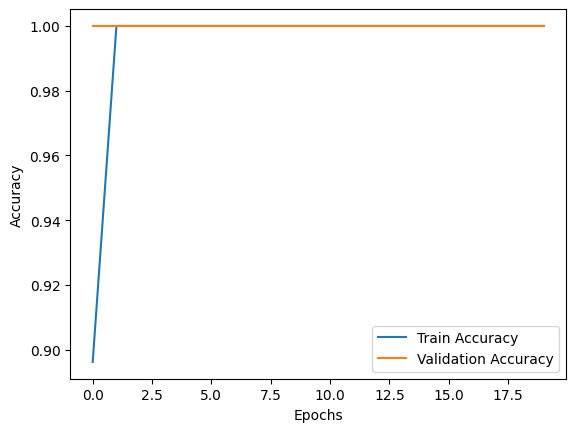

In [137]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Observations

- The model achieved **100% accuracy** on the test set.
- The training and validation accuracy curves **immediately reached 1.0**, which suggests the model **may be overfitting**.
- The loss value is extremely low, indicating that the model has learned the dataset perfectly.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


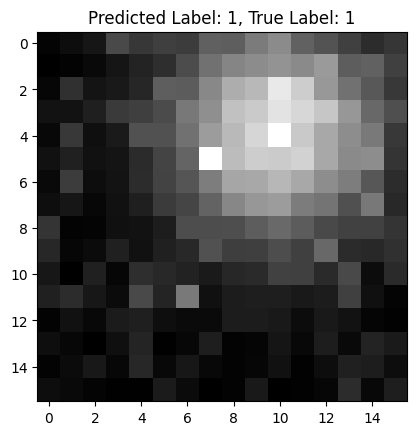

In [138]:
import random

# Pick a random test image
index = random.randint(0, len(X_test) - 1)
image = X_test[index]

# Predict
prediction = model.predict(image.reshape(1, 16, 16, 1))
predicted_label = 1 if prediction > 0.5 else 0  # Apply threshold

# Show result
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Predicted Label: {predicted_label}, True Label: {y_test[index]}")
plt.show()

#### On checking a random image you can see the model classifies it correctly

In [139]:
from sklearn.metrics import confusion_matrix

# Get model predictions
y_pred_probs = model.predict(X_test)  # Get probabilities
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convert to 0 or 1

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Extract TP, FP, FN, TN
TN, FP, FN, TP = cm.ravel()

# Convert into a 2x2 array for visualization
conf_matrix = np.array([[TN, FP], [FN, TP]])
labels = ["True Negative (TN)", "False Positive (FP)", "False Negative (FN)", "True Positive (TP)"]

print(f"Confusion Matrix:\n{conf_matrix}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Confusion Matrix:
[[ 97   0]
 [  0 103]]


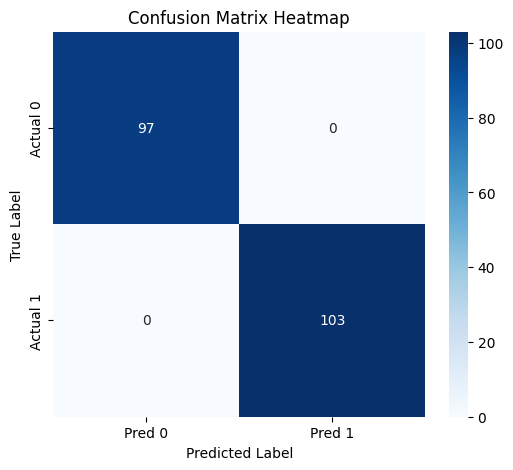

In [140]:
plt.figure(figsize=(6,5))
sb.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["Pred 0", "Pred 1"], yticklabels=["Actual 0", "Actual 1"])

# Labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")

# Show plot
plt.show()

### Observations
- From above it is further clear that the model has 100% accuracy as it has no False Positives or False Negatives